In [26]:
import pickle
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from itertools import product
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.rcParams['font.size'] = 18

In [7]:
# reading in byte-saved variables created by preferences.py that are the same for each run
with open('adjacency.pickle', 'rb') as f:
    # A is the adjacency matrix
    # indexmap maps user_ids to the row indices of A
    # indexmap_back maps row indices of A to user_ids
    # seed is a boolean vector of the initial infected nodes
    A, indexmap, indexmap_back, seed = pickle.load(f)

In [8]:
# adoption times of nodes, index is the adjacency matrix index
original_timeline = pd.read_csv('./vertices_fs.csv')
abm_timelines = pd.read_csv('adoption_times.csv')
timelines = pd.merge(original_timeline,abm_timelines,left_on="id",right_on="node_id")
timelines["new_id"] = timelines["id"].map(indexmap)
timelines.set_index("new_id",inplace=True)
timelines.head()

,id,comm_mem,cityid,month,node_id,ABM1,ABM2
new_id,,,,,,,
24550,72367576,55,78567,78.0,72367576,96.0,55.0
68,64248926,55,379,120.0,64248926,77.0,81.0
23282,70127822,218,46758,94.0,70127822,69.0,65.0
39036,71295318,167,393,84.0,71295318,53.0,71.0
22556,71889448,55,13943,80.0,71889448,49.0,72.0


In [9]:
# calculating the adoption category time bins
percentile_dict = {}
for col in ["month","ABM1","ABM2"]:
    percentile_dict[col] = np.percentile(timelines[col].dropna(),[0,2.5,16,50,84,100])

In [10]:
# getting the adjacency matrix ids of innovators and early adopters
categories = {}
category_names = {
    0: "innovators",
    1: "early_adopters",
    2: "early_majority",
    3: "late_majority",
    4: "laggards"
}


for i in range(5):
    category = category_names[i]
    for col in ["month","ABM1","ABM2"]:
        if category in categories:
            categories[category][col] = np.array(list(map(lambda x: indexmap[x],list(timelines["id"][(timelines[col]>=percentile_dict[col][i])&(timelines[col]<percentile_dict[col][i+1])]))))
        else:
            categories[category] = {}
            categories[category][col] = np.array(list(map(lambda x: indexmap[x],list(timelines["id"][(timelines[col]>=percentile_dict[col][i])&(timelines[col]<percentile_dict[col][i+1])]))))

In [11]:
# checking how many users have been sorted into the different categories
for k in categories:
    for k2 in categories[k]:
        print(k,k2,len(categories[k][k2]))
    print()

innovators month 6428
innovators ABM1 6776
innovators ABM2 6555

early_adopters month 32821
early_adopters ABM1 36279
early_adopters ABM2 34595

early_majority month 94511
early_majority ABM1 91575
early_majority ABM2 90289

late_majority month 93013
late_majority ABM1 91004
late_majority ABM2 92999

laggards month 45101
laggards ABM1 46079
laggards ABM2 47010



In [12]:
# city-city distance matrix
citydist = pd.read_csv("city_dist.csv",sep=";")
citydist["tup"] = citydist.apply(lambda row: (int(row["cityid1"]),int(row["cityid2"])),axis=1)
cd = citydist.fillna(0).set_index("tup")["distkm"].to_dict()

In [13]:
# creating dicts for faster access by user_id
cities = timelines["cityid"].to_dict()

# creating set from edgelist for fast containment checks
elist_set = set(list(zip(*A.nonzero())))

In [ ]:
# dumping output
output = "gravity_res_big.json"
# clear file (it should be more sophisticated!)
open(output,"w").close()

for col in ["month","ABM1","ABM2"]:
    for cat in [category_names[i] for i in range(5)]:
        print(col,cat)
        gravity_dict={}
        def attr(e,b=10):
            global gravity_dict
            if e[0]<e[1]:
                edge=int(e in elist_set)
                d=cd[(cities[e[0]],cities[e[1]])]
                d_trunc = int(d/b)*b
                if d_trunc in gravity_dict:
                    gravity_dict[d_trunc][edge]+=1
                else:
                    gravity_dict[d_trunc] = {edge: 1, int(not edge):0}
        total_pairs = len(categories[cat][col])**2
        for i,e in enumerate(product(categories[cat][col],categories[cat][col])):
            attr(e)
            if i%1000000==0:
                print(str(round(100*i/total_pairs,2))+'%',end=", ")
        
        # writing calculated output
        print("Dumping gravity data row.")
        f = open(output,"a")
        f.write(json.dumps({"data_source":col,"category":cat,"gravity_dict":gravity_dict}))
        f.write("\n")
        f.close()
        print()

In [57]:
# exporting gravity plot data for Balazs
d = []
for col in pd.DataFrame(gravity_res):
    d.append(pd.DataFrame(gravity_res)[col].map(lambda d: d[1]/(d[1]+d[0])))
d = pd.DataFrame(d).T
d.index = pd.DataFrame(gravity_res).index
d.reset_index().rename({"index":"d","month":"data"},axis=1).to_csv("gravity_plot.csv",index=False)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


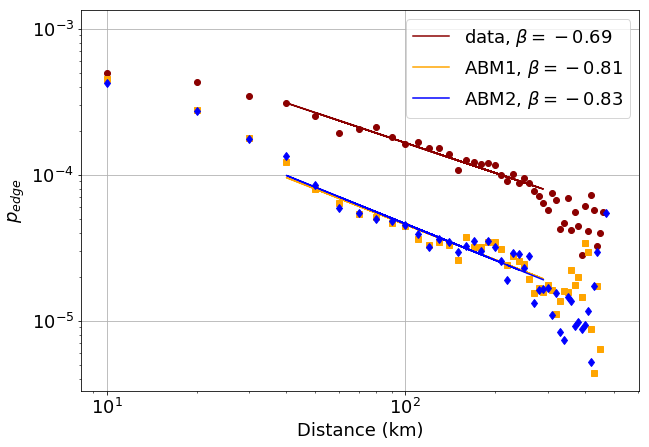

In [62]:
# gravity plots of selected categories
plt.figure(figsize=(10,7))

for col,marker,line,color in zip(gravity_res.keys(),['o','s','d'],['-','-','-'],['darkred','orange','blue']):
    res = {k: gravity_res[col][k][1] / (gravity_res[col][k][0] + gravity_res[col][k][1]) for k in gravity_res[col]}
    x = np.array([k for k in res])
    y = np.array([res[k] for k in res])
    def f(x,a,b):
        return a*x+b
    m = (x>30)&(x<300)
    p,pcov = curve_fit(f,np.log(x)[m],np.log(y)[m])
    plt.plot(x,y,marker,color=color)
    if col=="month":
        label="data"
    else:
        label=col
    plt.plot(x[m],np.exp(f(np.log(x)[m],*p)),line,color=color,label=label+r", $\beta=%.2f$" % p[0])
plt.loglog()
plt.legend()
plt.grid()
plt.xlabel("Distance (km)")
plt.ylabel(r"$p_{edge}$")
plt.savefig("gravity_plots.png",density=300)

# Data export

In [ ]:
d = []
with open("gravity_res_big_formatted.json") as f:
    for line in f:
        d.append(json.loads(line.strip("\n")))

df = pd.DataFrame.from_dict(d)

def data_series(d,t):
    temp = []
    for k in d:
        temp.append((float(k),d[k]['1']/d[k]['0']))
    return pd.DataFrame(temp).rename({1:t},axis=1).set_index(0)

for key in ["month","ABM1","ABM2"]:
    pd.concat(df[df.data_source == key]\
        .apply(lambda row: data_series(row["gravity_dict"],row["category"]),axis=1)\
        .to_list(),axis=1)\
        .fillna(0)\
        .reset_index()\
        .rename({0:"d_km"},axis=1)\
        .to_csv("gravity_plot_"+key+".csv")